# Task 3 - Correlation Between News Sentiment and Stock Movements

### Improting Libraries

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


### Load News Data

In [15]:
news_df = pd.read_csv(r"C:\KAIM\week-1\financial-news-sentiment-analysis\data\raw_analyst_ratings.csv")
news_df.head()
news_df.info()
news_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

### Clean the Data

In [16]:
import pytz

# First, convert Python datetime to pandas Timestamp
news_df['date'] = news_df['date'].apply(pd.Timestamp)
news_df.columns = news_df.columns.str.lower().str.strip()
news_df.drop_duplicates(inplace=True)
# Then make everything UTC
news_df['date'] = news_df['date'].apply(lambda x: x.tz_convert('UTC') if x.tzinfo else x.tz_localize('UTC'))

news_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   unnamed: 0  1407328 non-null  int64              
 1   headline    1407328 non-null  object             
 2   url         1407328 non-null  object             
 3   publisher   1407328 non-null  object             
 4   date        1407328 non-null  datetime64[ns, UTC]
 5   stock       1407328 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 64.4+ MB


## Sentiment Analysis

In [18]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the function and expand the tuple into two columns
news_df[['polarity', 'subjectivity']] = news_df['headline'].apply(lambda x: pd.Series(get_sentiment(x)))

# Check the result
news_df.head()

,unnamed: 0,headline,url,publisher,date,stock,polarity,subjectivity
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,0.0,0.0
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,0.0,0.0
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,0.0,0.0
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,0.0,0.0
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,0.0,0.0


### Aggregating Daily Sentiment per Stock

If multiple articles exist for the same stock on the same day, we average their sentiment scores to get one daily sentiment metric per stock.

In [20]:
daily_sentiment = news_df.groupby(["stock", "date"])["polarity"].mean().reset_index()
daily_sentiment.head()


,stock,date,polarity
0,A,2009-04-29 00:00:00+00:00,0.0
1,A,2009-06-01 00:00:00+00:00,0.0
2,A,2009-07-14 00:00:00+00:00,0.0
3,A,2009-07-30 00:00:00+00:00,0.0
4,A,2009-08-04 00:00:00+00:00,0.0


### Merging with Stock Daily Returns

In [ ]:
import pickle
# Prepare daily returns DataFrame
with open("../data/processed_stocks.pkl", "rb") as f:
    processed_stocks = pickle.load(f)



# Ensure index is datetime64[ns] without timezone
for symbol, df in processed_stocks.items():
    processed_stocks[symbol].index = pd.to_datetime(df.index).tz_localize(None)

# Prepare daily returns DataFrame
returns_df_list = []
for symbol, df in processed_stocks.items():
    temp = df[["daily_return"]].copy()
    temp["date"] = df.index  # already datetime64[ns]
    temp["stock"] = symbol
    returns_df_list.append(temp.reset_index(drop=True))

returns_df = pd.concat(returns_df_list, ignore_index=True)

# Ensure daily_sentiment['date'] is also datetime64[ns] without timezone
daily_sentiment["date"] = pd.to_datetime(daily_sentiment["date"]).dt.tz_localize(None)

# Merge sentiment with stock returns
merged_df = pd.merge(daily_sentiment, returns_df, on=["stock", "date"], how="inner")
merged_df.head()


,stock,date,polarity,daily_return
0,AAPL,2020-03-09,-0.155556,-0.079092
1,AAPL,2020-03-10,0.021708,0.072022
2,AAPL,2020-03-11,0.018624,-0.034730
3,AAPL,2020-03-12,-0.083048,-0.098755
4,AAPL,2020-03-13,0.069215,0.119808


### Correlation Analysis

We compute the Pearson correlation coefficient for each stock to measure the linear relationship between daily sentiment and daily returns:

- Value near +1 → strong positive correlation

- Value near -1 → strong negative correlation

- Value near 0 → no linear correlation

P-value < 0.05 indicates the correlation is statistically significant.

In [24]:
# Compute Pearson correlation for each stock
correlations = {}
for symbol in processed_stocks.keys():
    temp = merged_df[merged_df["stock"] == symbol]
    if len(temp) > 1:
        corr, pval = pearsonr(temp["polarity"], temp["daily_return"])
        correlations[symbol] = {"pearson_corr": corr, "p_value": pval}

correlations


{'AAPL': {'pearson_corr': np.float64(0.1459790755147175),
  'p_value': np.float64(0.26993256612663874)},
 'AMZN': {'pearson_corr': np.float64(-0.07445725527467868),
  'p_value': np.float64(0.7177336682040394)},
 'GOOG': {'pearson_corr': np.float64(0.05754563257081773),
  'p_value': np.float64(0.28508117036326036)},
 'NVDA': {'pearson_corr': np.float64(0.10298666145122913),
  'p_value': np.float64(0.0005534226299095864)}}

In [26]:
# Pivot data: rows = date, columns = stock, values = daily return
returns_pivot = merged_df.pivot(index="date", columns="stock", values="daily_return")
sentiment_pivot = merged_df.pivot(index="date", columns="stock", values="polarity")

# Combine daily returns and sentiment into one DataFrame
combined_df = pd.concat(
    [returns_pivot.add_suffix("_return"), sentiment_pivot.add_suffix("_sentiment")], axis=1
)

# Compute correlation matrix
corr_matrix = combined_df.corr()
corr_matrix


stock,AAPL_return,AMZN_return,GOOG_return,NVDA_return,AAPL_sentiment,AMZN_sentiment,GOOG_sentiment,NVDA_sentiment
stock,,,,,,,,
AAPL_return,1.000000,0.677101,0.932124,0.892891,0.145979,-0.221534,0.207581,0.275415
AMZN_return,0.677101,1.000000,0.540152,0.486629,0.109052,-0.074457,0.158193,0.309825
GOOG_return,0.932124,0.540152,1.000000,0.675322,0.134185,-0.117172,0.057546,0.010856
NVDA_return,0.892891,0.486629,0.675322,1.000000,0.091225,-0.212668,0.094358,0.102987
AAPL_sentiment,0.145979,0.109052,0.134185,0.091225,1.000000,0.301749,0.103053,0.048855
AMZN_sentiment,-0.221534,-0.074457,-0.117172,-0.212668,0.301749,1.000000,0.163001,-0.210024
GOOG_sentiment,0.207581,0.158193,0.057546,0.094358,0.103053,0.163001,1.000000,0.003255
NVDA_sentiment,0.275415,0.309825,0.010856,0.102987,0.048855,-0.210024,0.003255,1.000000


We pivot the data so that each stock is a column and each row represents a trading day.

- _return columns contain daily returns

- _sentiment columns contain average daily sentiment

Then we compute a Pearson correlation matrix for all returns and sentiment columns.
This allows us to see relationships between returns, between sentiment, and between sentiment & returns.

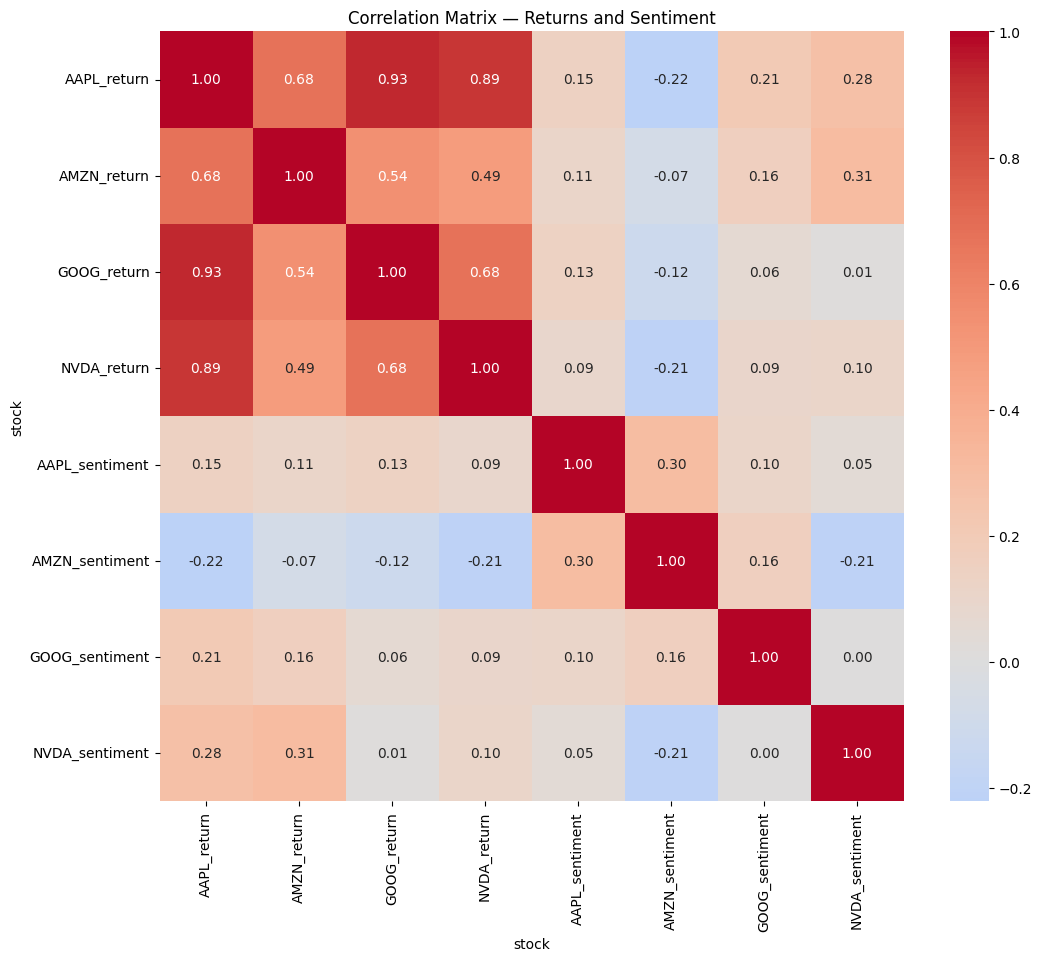

In [27]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix — Returns and Sentiment")
plt.show()


This 3×2 grid of scatter plots visualizes the relationship between average daily sentiment and daily returns for all six stocks.

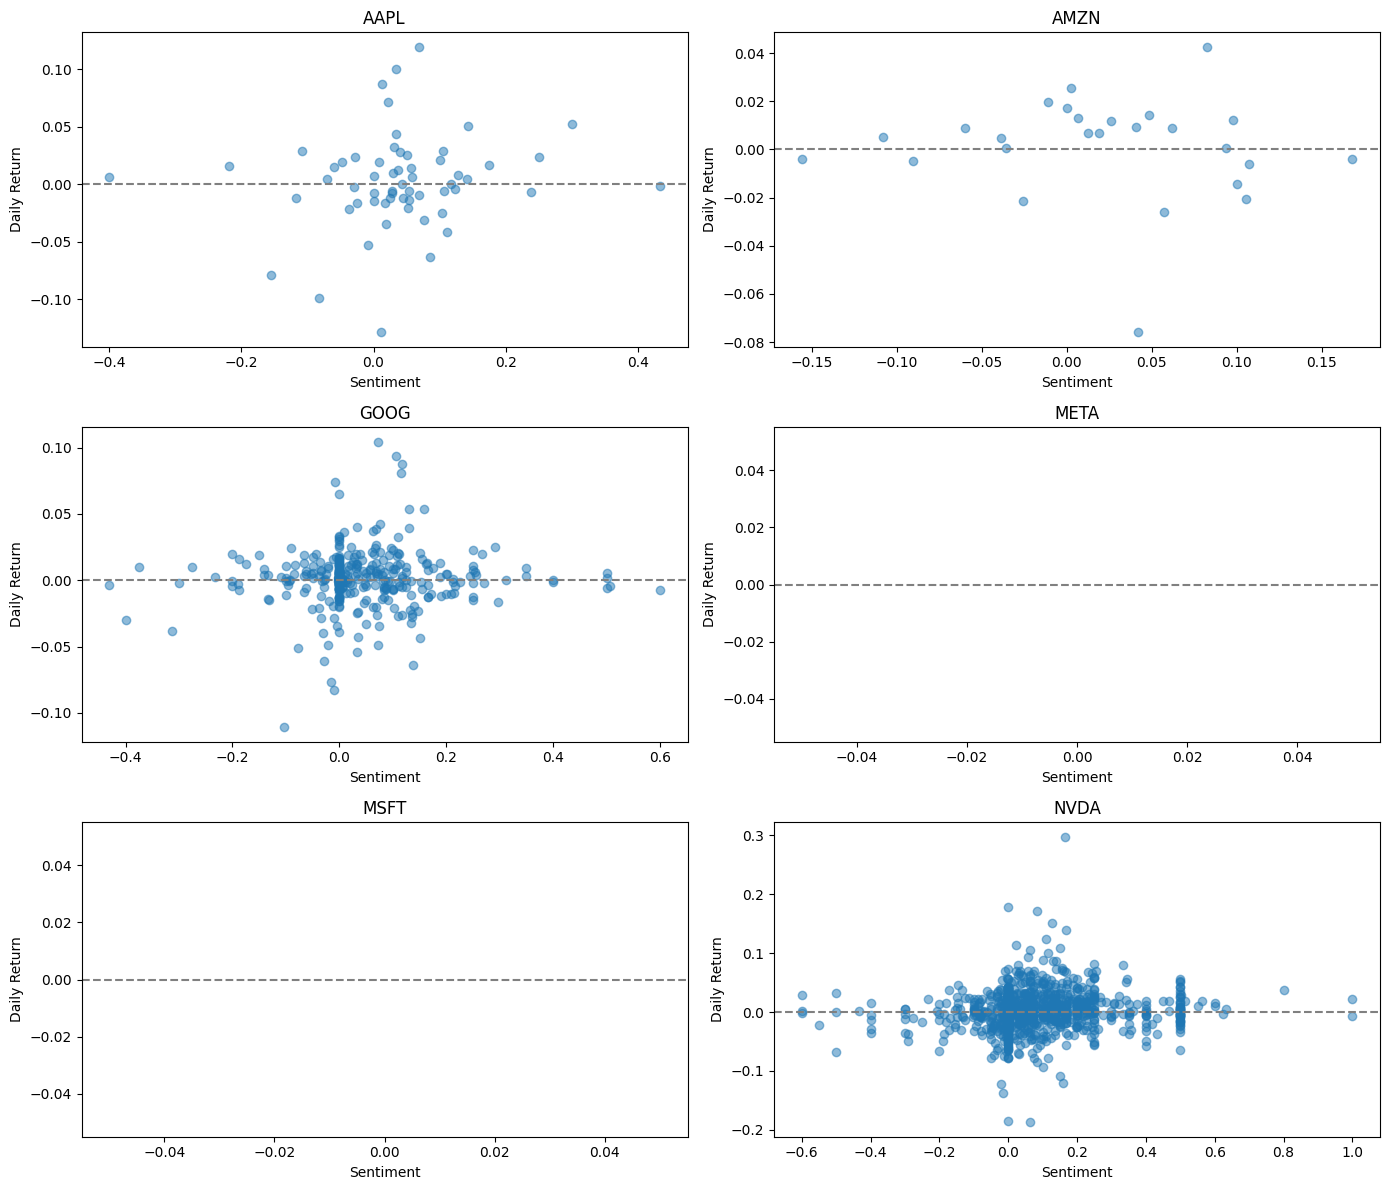

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(14,12))
axes = axes.flatten()

for i, symbol in enumerate(processed_stocks.keys()):
    temp = merged_df[merged_df["stock"] == symbol]
    axes[i].scatter(temp["polarity"], temp["daily_return"], alpha=0.5)
    axes[i].axhline(0, linestyle="--", color="gray")
    axes[i].set_title(symbol)
    axes[i].set_xlabel("Sentiment")
    axes[i].set_ylabel("Daily Return")

plt.tight_layout()
plt.show()


There were no headline information for MSFT and META that's why they're empty.

### Summary Table


This table summarizes the correlation coefficients and p-values for each stock, which can be included in reports or dashboards.

In [31]:
correlation_df = pd.DataFrame(correlations).T.reset_index()
correlation_df = correlation_df.rename(columns={"index": "Stock"})
correlation_df


,Stock,pearson_corr,p_value
0,AAPL,0.145979,0.269933
1,AMZN,-0.074457,0.717734
2,GOOG,0.057546,0.285081
3,NVDA,0.102987,0.000553
